# The Convolutional Classifier

**1. Introduction**

This course will introduce you to the fundamental ideas of computer vision. Our goal is to learn how a neural network can "understand" a natural image well-enough to solve the same kinds of problems the human visual system can solve.

The neural networks that are best at this task are convolutional neural networks (Sometimes we say covnet of CNN instead). Convolution is the mathematical operation that gives the layers of a covnet their unique structure. 

W will apply these ideas to the problem of image classification : given a picture, can we train a computer to tell us what it's a picture of? You may have seen aps that can identify a species of plant from a photograph. That's an image classifier. 

While our focus will be on image classification, what we'll learn is relevant to every kind of computer vision problem. 

**2. The Convolutional Classifier**

A covnet used for image classification consists of two parts : a convolutional base and a dense head.

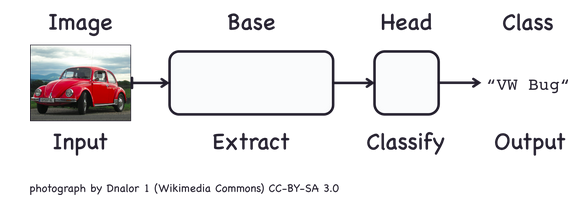

The base is used to extract features from an image. It is formed primarily of layers performing the convolution operation, but often includes other kinds of layers as well. 

The head is used to determine the class of the image. It is formed primarily of dense layers, but might include other layers like dropout. 

What do we mean by visual picture? A feature could be a line, a color, a texture, a shape, a pattern or some complicated combination. 

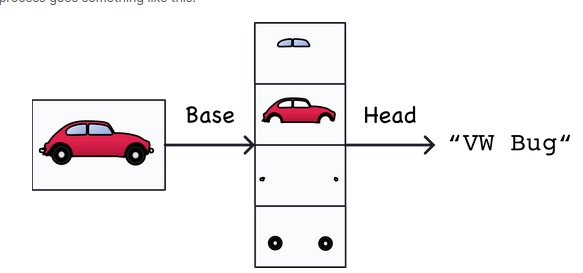

**3. Training the Classifier**

The goal of the network during training is to learn two things : 

1. which features to extract from an image(base),
2. which class goes with what features(head)

These days, covnets are rarely trained from scratch. More often, we reuse the base of a pretrained model. To the pretrained base we then attach an untrained head. In other words, we reuse the part of a network that has already learned to do 1. and attach to it some fresh layers to learn 2. 

Because the head usually consists of only a few dense layers, very accurate classifier can be created from relatively little data. 

Reusing a pretrained model is a technique known as transfer learning. It is so effective, that almost every image classifier these days will make use of it.

**4. Example**

Throughout this course, we're going to creating classifiers that attemp to solve the following problem : is this a picture of a Car or of a Truck? Our dataset is about 10,000 picture of various automobiles, around half cars and half trucks.

**Step1 : Load data**


In [3]:
# Imports 

import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

ImportError: SystemError: <built-in method __contains__ of dict object at 0x7f54b0c45340> returned a result with an error set

In [ ]:
# Reproducability

def set_seed(seed = 31415) : 
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.entiron['TF_DETERMINISTIC_OPS'] = '1'
set_seed(31415)


# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells

In [ ]:
# Load training and validation sets
ds_train_ = image_dataset_from_directory(
    '../input/car-or-truck/train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
ds_valid_ = image_dataset_from_directory(
    '../input/car-or-truck/valid',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

In [ ]:
# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE

ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

**Step 2 : Define Pretrained Base**

The most commonly used dataset for pretrianing is ImageNet, a large dataset of many kind of natural images. Keras includes a variety models pretrained on ImageNet in its applications module. The pretrained model we'll use is called VGG16.


In [ ]:
pretrained_base = tf.keras.models.load_model(
    '../input/cv-course-models/cv-course-models/vgg16-pretrained-base',
)
pretrained_base.trainable = False

**Step 3 : Attach Head**

Next, we attach the classifier head. For this example, we'll use a layer of hidden units followed by layer to tarnsform the outputs to a probability score for class 1, Truck. The Flatten layer transforms the two dimensional outputs of the base into the one dimensional inputs needed by the head.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    pretrained_base,
    layers.Flatten(),
    layers.Dense(6, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

**Step 4 : Train**

Finally, let's train the model. Since this is a two-class problem, we'll use the binary versions of crossentropy and accuracy. The adam optimzer generally performs well, so we'll choose it as well.

In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=30,
    verbose=0,
)

When training a neural network, it's always a good iedea to examine the loss and metric plots. The history object contains this information in a dictionary history.history. We can use Pandas to convert this dictionary to a dataframe and plot it with a bulit-in method. 

In [ ]:
import pandas as pd

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

# Convolution and ReLU

**1. Introduction**

In the last lesson, we saw that a convolutional classifier has two parts : a convolutional base and a head of dense layer. We learned that the job of the base is to extract visual features from an image, which the head would then use to classify the image. 

Over the next few lessons, we're going to learn about the two most important types of layers that you'll usually find in the base of convolutional image classifier. These are the convolutional layer with ReLU activation, and the maximum pooling layer. In Lesson 5, you'll learn how to design your own covnet by composing these layers into blocks that perform the feature extraction. 

This lesson is about the convolutional layer with its ReLU activation function.

**2. Feature Extraction**

Before we get into the details of convolution, let's discuss the purpose of these layers in the networks. We're going to see how these three operations(convolution, ReLU, and maximum pooling) are used to implement the feature extraction process.

The feature extraction performed by the base consists of three basic operations. 

1. Filter an image for a particular featrue (convolution)
2. Detect that feature within the filtered image (ReLU)
3. Condense the image to enhance the features (maximum pooling)

The next figure illustrates this process. You can see how these three operations are able to isolate some particular characterisitc of the original image (in this case, horizontal lines). 

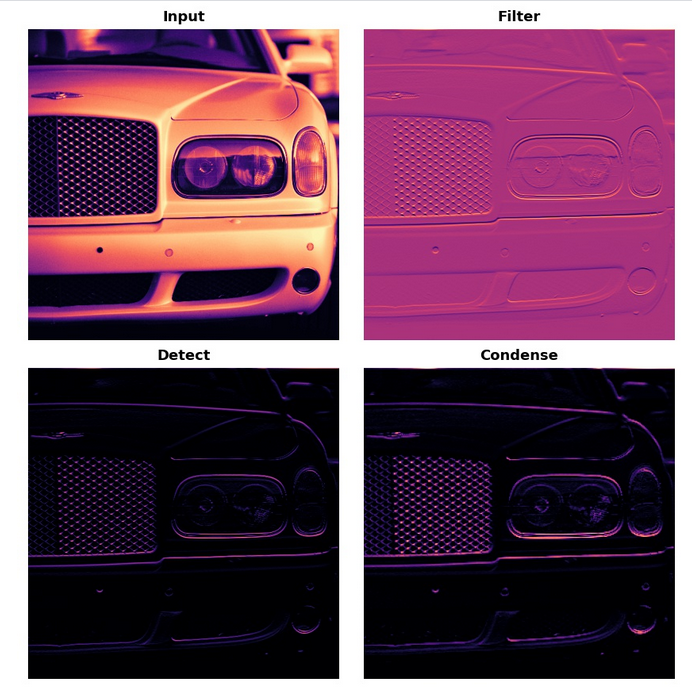

Typically, the network will perform several extractions in parallel on a single image. In modern covnets, it's not uncommon for the final layer in the base to be producing 1000 unique visual features. 

**3. Filter with Convolution**

A convolutional layer carries out the filtering step. You might define a convolutional layer in a Keras model something like this :

In [ ]:
from tensorflow import Keras
from tensorflow.keras import layers 

model = keras.Sequential([
    layers.Conv2D(filter = 64, kernel_size = 3)
])

We can understand these parameters by looking at their relationship to the weights and activations of the layer.

**4. Weights**

The weights a covnet learns during training are primarily contained in its convolutional layers. These weights we call kernels. We can represent them as small arrays : 

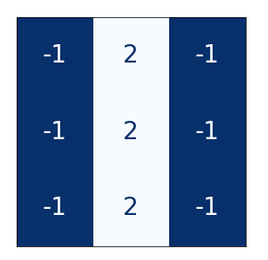

A kernel operates by scanning over an image and producing a weighted sum of pixel values. In this way, a kernel will act sort of like polarized lens, emphasizing or deemphasizing certain patterns of information. 

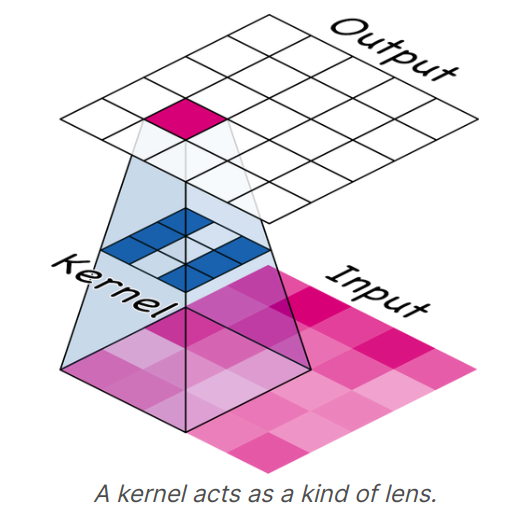

Kernels define how a convolutional layer is connected to the layer that follows. The kernel above will connect each neuron in the output to nine neurons in the input. By setting the dimensions of the kernels with kernel_sizde, you are telling the covnet how to form these connections. Most often, a kernel will have odd-numbered dimensions -- like kernel_size = (3,3) or (5,5) -- so that a single pixel sits at the center, but this is not a requirement. 

The kernels in a convolutional layer determine what kinds of feature it creates. During training, a covnet tries to learn what featurees it needs to solve the classification problem. This means finding the best values for its kernels. 

**5. Activations**

The activiations in the network we call feature maps. They are what result when we apply a filter to an image; they contain the visual features the kernel extracts. 

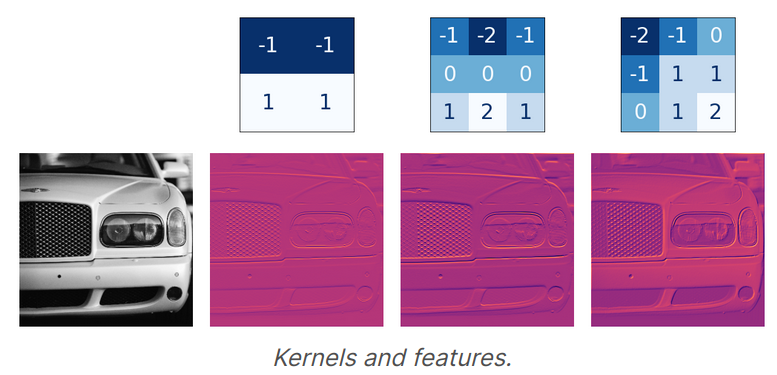

From the pattern of numbers in the kernel, you can tell the kinds of feature map it creates. Generally, what a convolution accentuates in its inputs will match the shape of the positive numbers in the kernel. The left and middle kernels above will both filter for horizontal shape.

With the filters parameter, you tell the convolutional layer how many feature maps you want it to create as output. 

**6. Detect with ReLU**

After filtering, the feature maps pass through the activation function. A neuron with a rectifier attached is called a rectified linear unit. For that reason, we might also call the rectifier function the ReLU activation or even the ReLU function. 

The ReLU activation can be defined in its own Activation layer, but most often you'll just include it as the activation function of Conv2D.

In [ ]:
model = keras.Sequential([
    layers.Conv2D(filters=64, kernel_size=3, activation='relu')
    # More layers follow
])

You could think about the activation function as scoring pixel values according to some measure of importance. The ReLU activation says that negative values are not important and so sets them to 0. ("Everyting unimportnat is equally unimportant.")|

# Maximum Pooling

# The Sliding Window

# Custom Convnets

# Data Argumentation